# Modelo de identificação de Veículos

## Importando bibliotecas

In [1]:
import cv2
import numpy as np
import imutils
import pytesseract
import matplotlib.pyplot as plt

## Funções da aplicação

Define funções da aplicação para identificação de veículos.


In [2]:
def process_image(img):
    
    (H,W) = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    if screenCnt is None:
        detected = False
        # print ("No contour detected")
        return None, detected, None, None, None, None
    else:
        detected = True

        mask = np.zeros(gray.shape,np.uint8)
        new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
        new_image = cv2.bitwise_and(img,img,mask=mask)
        (x, y) = np.where(mask == 255)

        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        Cropped = gray[topx:bottomx+1, topy:bottomy+1]

        return Cropped, detected, topx, topy, bottomx, bottomy

In [3]:
def show_image(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray')
    plt.show()
    

In [4]:
def crop_image(img):
    img = cv2.resize(img, (500, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = img[0:img.shape[0], 0:int(img.shape[1]/2)]
    show_image(img1)
    img2 = img[0:img.shape[0], int(img.shape[1]/2):img.shape[1]]
    show_image(img2)
    img3 = img[0:int(img.shape[0]/2), 0:img.shape[1]]
    show_image(img3)
    img4 = img[int(img.shape[0]/2):img.shape[0], 0:img.shape[1]]
    show_image(img4)
    img5 = img[int(img.shape[0]/2):img.shape[0], int(img.shape[1]/2):img.shape[1]]
    show_image(img5)
    return [img1, img2, img3, img4, img5]

In [5]:
def get_text(img):
    alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    config = F"-c tessedit_char_whitelist={alphanumeric} --tessdata-dir tessdata --psm 8"
    text = pytesseract.image_to_string(img, lang="eng", config=config)
    text = "".join([c for c in text if c.isalnum()])
    return text

In [6]:
def generate_plate(placa: str) -> list :
    placas = []
    placas.append(placa.replace('G', '0'))
    placas.append(placa.replace('G', 'Q'))
    placas.append(placa.replace('0', 'G'))
    placas.append(placa.replace('0', 'Q'))
    placas.append(placa.replace('Q', 'G'))
    placas.append(placa.replace('Q', '0'))

    return placas

In [7]:
! export TESSDATA_PREFIX="/home/matheus/Documents/UnB/PI2/IA/tessdata/"

## Experimentação da Utilização de um Modelo de Machine Learning

Utilizando o modelo de Machine Learning para identificar os veículos de algumas imagens.

images/carro1.jpg


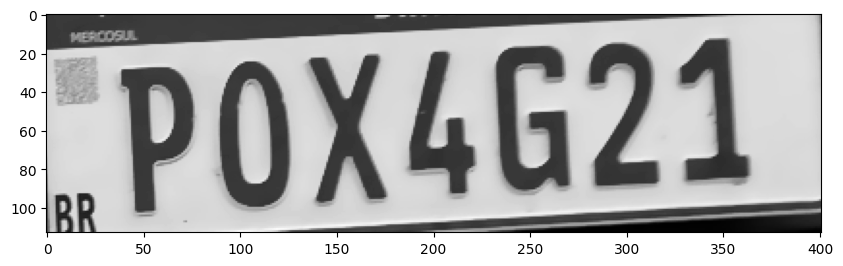

### POX4G24

images/carro2.jpg


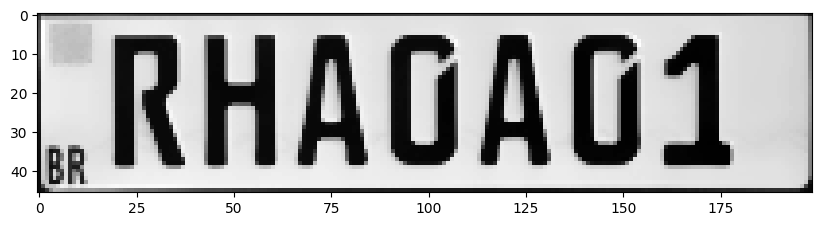

### RHAGAG1

images/carro3.jpg


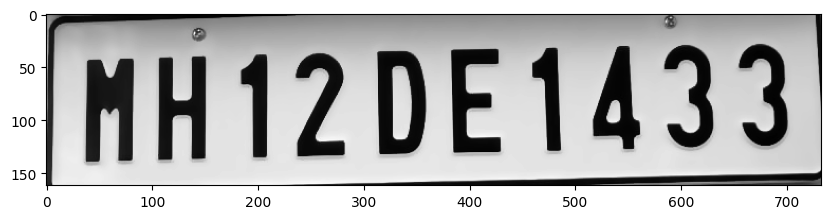

### MH12DE1433

images/carro4.jpg


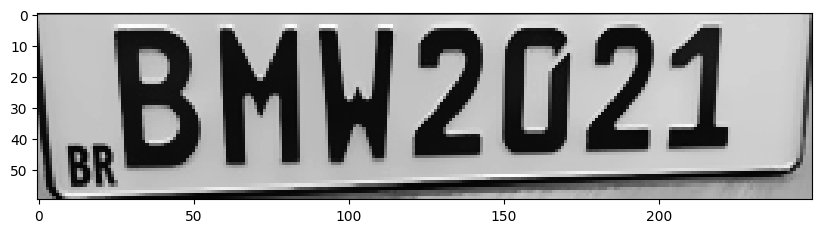

### BMW2621

images/carro5.jpg


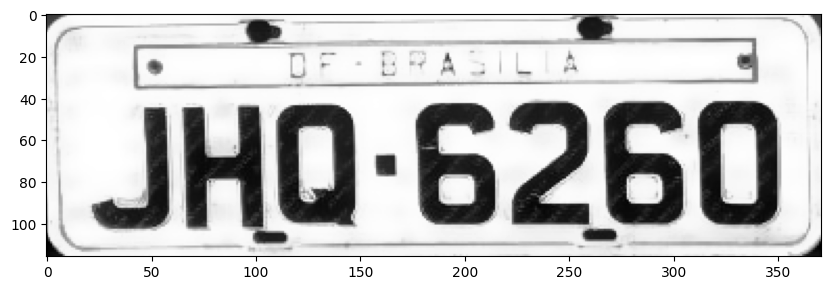

### JHO6260

In [8]:
from IPython.display import display, Markdown, Latex
for i in range(1, 6):
    print(f'images/carro{i}.jpg')
    img = cv2.imread(f'images/carro{i}.jpg')
    img, detected, topx, topy, bottomx, bottomy = process_image(img)
    if detected:
        show_image(img)
        display(Markdown('### ' + get_text(img)))

## Análise em tempo real

Utilizando o modelo de Machine Learning para identificar os veículos em tempo real, integrando o modelo com a camera do computador.

In [9]:
import cv2 as cv
from time import sleep
import requests

cam = cv.VideoCapture(2)

while True:
    status, frame = cam.read()

    if not status:
        break

    if cv.waitKey(1) & 0xff == ord('q'):
        break
    
    img, detected, topx, topy, bottomx, bottomy = process_image(frame)
    if detected:
        cv.rectangle(frame,(topy,topx),(bottomy,bottomx),(0,255,0), 3)
        cv.putText(frame,"Contorno Encontrado",(0 + 200,0 + 0 + 50), cv.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv.LINE_AA)
        placa = get_text(img)
        cv.putText(frame,placa,(0 + 200,0 + 0 + 100), cv.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv.LINE_AA)

        headers = {
            "Content-Type": "application/json"
            }
        placa = placa.upper()
        if len(placa) == 7:
            if "0" not in placa and "Q" not in placa and "G" not in placa:
                response = requests.post("http://140.238.191.18:5000/estaciona", 
                json={"placa": placa}, 
                headers=headers)
                print(response.status_code)

                
                if response.status_code == 201:
                    text_data = response.json().get("message")
                    cv.putText(frame,text_data,(0 + 200,0 + 0 + 150), cv.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv.LINE_AA)
                    sleep(20)
            else:
                print("####################################")
                placas = generate_plate(placa)
                for placa in placas:
                    response = requests.post("http://140.238.191.18:5000/estaciona", 
                    json={"placa": placa}, 
                    headers=headers)
                    print(response.status_code)
                    if response.status_code == 201:
                        text_data = response.json().get("message")
                        cv.putText(frame,text_data,(0 + 200,0 + 0 + 150), cv.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv.LINE_AA)
                        sleep(20)
                        break
    else:
        prediction = 'SEM CONTORNO'
        cv.putText(frame,prediction,(0 + 200,0 + 0 + 50), cv.FONT_HERSHEY_COMPLEX,1,(0,40,255) , 2, cv.LINE_AA)

    cv.imshow("Screen",frame)
    # sleep(0.5)

: 